# CrossSim: a hardware/software co-design tool for analog in-memory computing

### Tutorial for CrossSim v3.0

www.cross-sim.sandia.gov/ <br>
www.github.com/sandialabs/cross-sim

## Outline

- Notebook 0: Installation
- Notebook 1: Overview of CrossSim: AnalogCores, and ADCs
- Notebook 2: Analog Torch networks
- Notebook 3: Analog SNNs

## What is CrossSim?

CrossSim is a modeling framework that is built mainly around a key analog computational primitive: matrix-vector multiplication (MVM) in a crossbar memory array. We'll primarily talk about a resistive crossbar array but the framework is general enough to encompass other in-memory computing systems (e.g. SRAM, DRAM). Crossbars can also implement outer product update, but we won't cover that in this tutorial.

<img src="https://www.sandia.gov/app/uploads/sites/110/2023/09/mvm.png" width="550" />

Analog MVM can potentially be very energy-efficient, fast, and compact, and this has made it an attractive recent area of research. But being analog rather than digital, these systems are also more susceptible to errors unless carefully designed. There are all sorts of errors that can creep in during the computation of an analog MVM. Listed below are just a few.


<img src="https://www.sandia.gov/app/uploads/sites/110/2023/09/mvm_nonideal.png" width="650" />


CrossSim is a tool that provides detailed models to propgate device- and circuit-level errors to the algorithm. It also serves as a multi-scale design space exploration tool from devices and circuits, architectures, and algorithms to ensure accuracy and reliability. CrossSim offers a unique combination of application versatility, modeling fidelity, modeling flexibility, and speed that make it well suited for hardware/software co-design. We'll show off some of this in this tutorial.

In this first notebook we will introduce the core components of CrossSim: AnalogCores which model the memristive devices, and ADCs which model the conversion from electrical current to voltage, to propagate up the network.

---

In [1]:
import sys
import numpy as np
import scipy.linalg
import scipy.sparse.linalg
import matplotlib.pyplot as plt
from PIL import Image
np.random.seed(198)
import os 

# CrossSim modules
import simulator
from simulator import AnalogCore
from applications.mvm_params import set_params

## Part 1: The AnalogCore interface

New in CrossSim 3.0 is an easy-to-use and highly flexible interface to simulate analog MVMs. To run this simulation, we create an object called an AnalogCore. As we'll show, the AnalogCore can then be dropped into arbitrary Python application code. The picture below shows the internal organization of an AnalogCore. On the left are the inputs to the core.

<img src="https://www.sandia.gov/app/uploads/sites/110/2023/09/AnalogCore_overview.png" width="650" />

### 1.1. AnalogCore API basics

#### 1.1.1. MVM

We'll start by using CrossSim's MVM functionality. As the simplest example, we'll start by multiplying a random matrix with a random vector.

In [2]:
# Define a random matrix W
N1, N2 = 300, 200
W = np.random.uniform(-1,1,size=(N2,N1))

# Define a random vector x
x = np.random.uniform(-1,1,size=(N1,))

# Compute the MVM in NumPy:
y_np = W @ x

Now let's compute the same thing using CrossSim's AnalogCore. We first set the hardware parameters of the analog IMC core we want to simulate. For now, we create a core that assumes ideal devices and circuits with infinite precision. This is the default case if no parameters are explicitly specified:

In [3]:
# Use default parameters
params = set_params()

# Create an AnalogCore, pass in the params, and program matrix
xbar = AnalogCore(W, params=params)

# Use the AnalogCore like a NumPy array
y_xsim = xbar @ x

Once created, the AnalogCore can be treated as if it were the familiar NumPy array, except that when multiplying by the AnalogCore, an analog MVM is being simulated!

Now let's compare CrossSim's MVM result with NumPy and plot the result. Since we assumed ideal analog hardware, they should match exactly.

In [4]:
assert(np.allclose(y_np,y_xsim))
print("--- MVM check passed! ---")

--- MVM check passed! ---


In general, you can utilize AnalogCore anywhere and anyway that you would use numpy matrices or vectors.

This includes applications such as numerical simulation, optimization, and others. The purpose of this tutorial is overall to build towards neural network simulations. The remainder of this notebook will analyze the different types device modeling that we can achieve.

#### 1.1.2. Re-programming a core

Now let's suppose that we would like to program a new matrix into the array. Rather than creating a new AnalogCore, we can re-program the same one. There are two ways to do this. The first is the set_matrix() method in AnalogCore:

In [5]:
# Create a new random matrix with the same dimensions and compute the NumPy MVM
W_new = np.random.uniform(-1,1,size=(N2,N1))
x = np.random.uniform(-1,1,size=(N1,))
y_np_new = W_new @ x

# Re-program the core, according to the original params
xbar.set_matrix(W_new)

# Run an MVM and check the result
y_xsim_new = xbar @ x

assert(np.allclose(y_np_new,y_xsim_new,atol=1e-6))
print("--- Core re-programming check #1 passed! ---")

--- Core re-programming check #1 passed! ---


We can also put the matrix to be programmed on the right side of an assignment. By including the [:] syntax, this will implicitly call set_matrix:

In [6]:
# Create another new random matrix with the same dimensions and compute the NumPy MVM
W_new2 = np.random.uniform(-1,1,size=(N2,N1))
y_np_new2 = W_new2 @ x

# Re-program the core again
xbar[:] = W_new2

# Run an MVM and check the result
y_xsim_new2 = xbar @ x

assert(np.allclose(y_np_new2,y_xsim_new2,atol=1e-6))
print("--- Core re-programming check #2 passed! ---")

--- Core re-programming check #2 passed! ---


Finally, we can use this syntax to partially re-program the memory array (and apply the associated programming errors, if enabled). The rest of the array will be left intact.

In [7]:
# Let's take the W_new2 matrix and change a 50x75 block of elements
W_new_block = np.random.uniform(-1,1,size=(50,75))
W_new2[50:100,75:150] = W_new_block

# Re-program a portion of the core
xbar[50:100,75:150] = W_new_block

# Run MVMs and check the result
y_np_new3 = W_new2 @ x
y_xsim_new3 = xbar @ x

assert(np.allclose(y_np_new3,y_xsim_new3,atol=1e-6))
print("--- Subarray re-programming check passed! ---")

--- Subarray re-programming check passed! ---


---
# 1.2: Analog Devices
To demonstrate the effects of various sources of error, we will implement the forward and inverse 2D Fourier Transforms.
We will evaluate the effects of read/write noise, parastic currents, quantized weights, and ADC precision on the precision of this algorithm


For more information on different methods to implement this, see Part 1 of the main CrossSim Tutorial (https://github.com/sandialabs/cross-sim/tree/main/tutorial)

![](./figs/error_sources.png)

In [8]:
# Load image
N_ft1, N_ft2, Nch = 256, 256, 3
image_path = os.path.join(os.path.split(os.path.split(simulator.__file__)[0])[0], 'applications','dsp','example_images','orchid.jpg')
X_flower = Image.open(image_path).resize((N_ft1,N_ft2))
X_flower = np.array(X_flower).astype(np.float32) / 255

Here is the block of code that takes the 2D DFT of this image, then takes the 2D inverse DFT of this image, using numpy MVMs.

In [9]:
def DFT(X):
    Y = np.zeros(X.shape, dtype=np.complex128)
    X_recon = np.zeros(X.shape, dtype=np.complex128)

    # DFT-256 matrix
    W_dft = scipy.linalg.dft(N_ft1)
    W_idft = np.matrix.getH(W_dft)
    
    Y = np.zeros(X.shape,dtype=np.complex128)
    X_recon = np.zeros(X.shape, dtype=np.complex128)
    
    # Forward 2D DFT
    for ch in range(Nch):
        y_imed = np.zeros((X.shape[1],X.shape[0]),dtype=np.complex128)
        for k in range(N_ft2):
            y_imed[k,:] = W_dft @ X[:,k,ch]
        for k in range(N_ft1):
            Y[k,:,ch] = W_dft @ y_imed[:,k]
            
    # Inverse 2D DFT
    for ch in range(Nch):
        x_imed = np.zeros((Y.shape[1],Y.shape[0]),dtype=np.complex128)
        for k in range(N_ft1):
            x_imed[k,:] = W_idft @ Y[:,k,ch]
        for k in range(N_ft2):
            X_recon[k,:,ch] = W_idft @ x_imed[:,k]
    
    # Normalize
    X_recon = np.real(X_recon / (N_ft1*N_ft2)).clip(0,1)

    return X_recon

To get the CrossSim version, we create two AnalogCores and simply replace "W" with "xbar" in the DFT loops.

In [10]:
# Create and program DFT AnalogCore
def DFT_CS(X, params=set_params(complex_matrix = True)):
    W_dft = scipy.linalg.dft(N_ft1)
    W_idft = np.matrix.getH(W_dft)
    xbar_dft = AnalogCore(W_dft, params=params)
    
    # Create IDFT AnalogCore
    xbar_idft = AnalogCore(W_idft, params=params)
    
    Y = np.zeros(X.shape,dtype=np.complex128)
    X_recon = np.zeros(X.shape, dtype=np.complex128)
    
    # Forward 2D DFT
    for ch in range(Nch):
        y_imed = np.zeros((X.shape[1],X.shape[0]),dtype=np.complex128)
        for k in range(N_ft2):
            y_imed[k,:] = xbar_dft @ X[:,k,ch]
        for k in range(N_ft1):
            Y[k,:,ch] = xbar_dft @ y_imed[:,k]
            
    # Inverse 2D DFT
    for ch in range(Nch):
        x_imed = np.zeros((Y.shape[1],Y.shape[0]),dtype=np.complex128)
        for k in range(N_ft1):
            x_imed[k,:] = xbar_idft @ Y[:,k,ch]
        for k in range(N_ft2):
            X_recon[k,:,ch] = xbar_idft @ x_imed[:,k]
    
    # Normalize
    X_recon = np.real(X_recon / (N_ft1*N_ft2)).clip(0,1)

    return X_recon

recon = DFT(X_flower)
recon_cs = DFT_CS(X_flower)

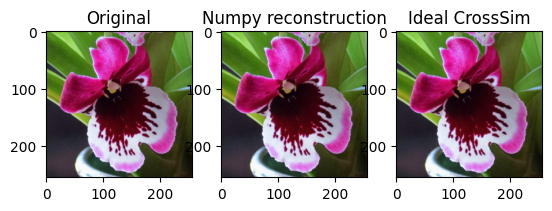

In [11]:
plt.subplot(131)
plt.imshow(X_flower)
plt.title('Original')
plt.subplot(132)
plt.imshow(recon)
plt.title('Numpy reconstruction')
plt.subplot(133)
plt.imshow(recon_cs)
plt.title('Ideal CrossSim');

In the above figure we see that the original image (left) is accurately reconstructed the forward then inverse DFT (middle). 
The CrossSim reconstruction (right) is also accurate because we have used ideal hardware simulations.

We next create a series of non-ideal hardware configurations and evaluate the effects on reconstruction accuracy. We will use a slightly modified version of the params API, which constructs a base set and allows us to easily access sub-sets of parameters

In [12]:
from simulator import CrossSimParameters
cs_params = CrossSimParameters()
# Remember to always allow for complex inputs and matrices in this example
cs_params.core.complex_input = True
cs_params.core.complex_matrix = True
print(cs_params)

CrossSimParameters: 
{'core': {'balanced': {'interleaved_posneg': False,
                       'style': <BalancedCoreStyle.ONE_SIDED: 1>,
                       'subtract_current_in_xbar': True},
          'bit_sliced': {'num_slices': 2,
                         'style': <BitSlicedCoreStyle.BALANCED: 1>},
          'cols_max': 1024,
          'complex_input': True,
          'complex_matrix': True,
          'mapping': {'inputs': {'_match': True,
                                 'mvm': {'clipping': False,
                                         'max': 1.0,
                                         'min': -1.0,
                                         'percentile': None},
                                 'vmm': {'clipping': False,
                                         'max': 1.0,
                                         'min': -1.0,
                                         'percentile': None}},
                      'weights': {'clipping': True,
                                  'co

This is a nested dictionary of parameters, each of which can be changed to match the level of detail we wish to model.
A complete explanation of this structure can be found in the CrossSim documentation.

In [13]:
# Let us first create a device which models the noise involved in writing to the analog array:
# -----------------------------------------------------------------------------------------------------
sonos_params = CrossSimParameters()
sonos_params.xbar.device.programming_error.model = 'SONOS'  # Experimentally defined write errors
sonos_params.xbar.device.programming_error.enable = True    # SONOS 
# Remember to always allow for complex matrices in this example
sonos_params.core.complex_matrix = True

# We can also introduce quantized weights
# -----------------------------------------------------------------------------------------------------
wq_params = CrossSimParameters()
wq_params.xbar.device.cell_bits = 4                      # Quantized Weights
wq_params.core.complex_matrix = True


#  Or quantized activations
# -----------------------------------------------------------------------------------------------------
qa_params = CrossSimParameters()
qa_params.xbar.adc.mvm.adc_range_option = "MAX"         # Calibrate ADC buckets based on expected values
qa_params.xbar.adc.mvm.bits = 8
qa_params.xbar.adc.mvm.model = 'QuantizerADC'            # Simple step-like quantization
qa_params.core.complex_matrix = True

# Or all of them at once
# -----------------------------------------------------------------------------------------------------
qaw_sonos_params = CrossSimParameters()
qaw_sonos_params.xbar.device.programming_error.model = 'SONOS'  # Experimentally defined write errors
qaw_sonos_params.xbar.device.programming_error.enable = True    # SONOS 
qaw_sonos_params.xbar.device.cell_bits = 4                      # Quantized Weights
qaw_sonos_params.xbar.adc.mvm.adc_range_option = "MAX"         # Calibrate ADC buckets based on expected values
qaw_sonos_params.xbar.adc.mvm.bits = 8
qaw_sonos_params.xbar.adc.mvm.model = 'QuantizerADC'            # Simple step-like quantization
qaw_sonos_params.core.complex_matrix = True


# This next version will introduce parasetic resistances into the array
# -----------------------------------------------------------------------------------------------------
parasitic_params = CrossSimParameters()
parasitic_params.xbar.array.parasitics.Rp_col = 1e-6 # Set parasitic resistances to 1 micro ohm
parasitic_params.xbar.array.parasitics.Rp_row = 1e-6
parasitic_params.xbar.device.Rmin = 1e3 # Analog resistance will vary from 1K Ohm
parasitic_params.xbar.device.Rmax = 1e6 # To one M Ohm
parasitic_params.xbar.array.parasitics.gate_input = False
parasitic_params.xbar.array.parasitics.enable = True
parasitic_params.core.complex_matrix = True

In [14]:
param_sets = [cs_params,
              sonos_params, 
              wq_params, #qa_params,
              #qaw_sonos_params,
              #parasitic_params, # Note: The parasitic simulation takes signifcantly more time, so it has been commented out by default
             ]

names = ['ideal',
         'sonos',
         'quant weights', 'quant act', 
         'quant weights + activation',
         'parasitics']

recon = list()
for i in range(0, len(param_sets)):
    recon.append(DFT_CS(X_flower, param_sets[i]))

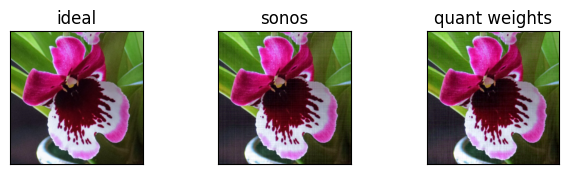

In [15]:
for i in range(0, len(recon)):
    plt.subplot(3,3,i+1)
    plt.imshow(recon[i])
    plt.title(names[i])
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

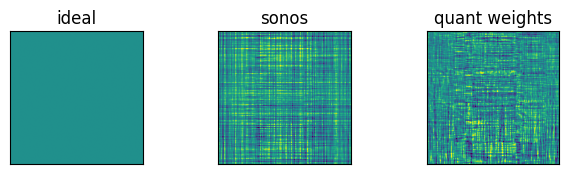

In [16]:
# We can also visualize the pixel-wise error (across all three channels) comapared to the ideal hardware

for i in range(0, len(recon)):
    plt.subplot(3,3,i+1)
    err = (recon[i] - recon[0]).sum(axis=-1)
    plt.title(names[i])
    plt.imshow(err, clim=[-.1,.1])
    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()